<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">

# <p style="text-align: center;">Lab 4 (Weeks 8,9): Convolutional Neural Networks (CNNs)</p>
## <p style="text-align: center;">Notebook II: Applications</p>

<img src="https://miro.medium.com/v2/resize:fit:592/1*V6Y8FF2qfw_ztNbs1AHXNg.png" width="800" height="400" />

<!-- ![linear-vs-logistic-regression--medium](https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg) -->

Welcome to the fourth and <b>final</b> lab! As usual, this lab will span over two weeks.
            
In this Lab, you will find four tasks distributed across two Jupyter Notebooks: *Lab4_Basics_student.ipynb* and *Lab4_Applications_student.ipynb*. The first two tasks guide you to train a basic CNN using pytorch lightning. In the last task, you will apply the knowledge you gained to solve a practical problem.
    
- <b>Task 1:</b> Design a CNN and train to classify STL-10 images
- <b>Task 2:</b> Analyse the results on the STL-10 test images
- <b>Task 3:</b> Design and train a CNN by yourself on the FER-4 dataset and analyse results
      
Each task will contain code to complete, and a worded question, so ensure you complete both before submitting. Feel free to add your own additional comments.
    
After completion, You need to submit both Jupyter Notebooks (.ipynb files) to Moodle. Make sure all the outputs are visible before submitting.
    
Good luck with the final Lab! Submit it before the <b>deadline</b> to enjoy full marks.

__Submission details:__
- __Make sure you have run all your cells from top to bottom (you can click _Kernel_ and _Restart Kernel and Run All Cells_).__ </br>
- __Submit the Jupyter Notebooks (Lab4_Basics.ipynb_) and (Lab4_Applications.ipynb_).__
- __Outputs must be visible upon submission. We will also be re-running your code__

<b>Enter you student details below</b>

- <b>Student Name:</b> Firstname Lastname
- <b>Student ID:</b> 123456789   

<div class="alert alert-block alert-danger">

## Table of Contents
    
* [Libraries](#Libraries)

* [Task 3: Design and train a CNN by yourself on the FER-4 dataset and Analyse Results](#task_3)

* [Discussion Questions](#t3_1)

<div class="alert alert-block alert-warning">

# Libraries

In this lab, you will use several pytorch and pytorch lightning libraries along with several other basic python libraries. All the libraries that you need are given below.

In [1]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import log_softmax, softmax
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
import torchmetrics
from torchsummary import summary

from IPython.display import display

import lightning as pl  ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress.tqdm_progress import TQDMProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import (
    RichProgressBarTheme,
    RichProgressBar,
)

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

Seed set to 4179


<div class="alert alert-block alert-warning">

# Facial Expression Recognition (FER) Dataset <a class="anchor" id="python-basics"></a>
    
For all the work in this notebook, you will be using the FER dataset.
    
<img src="https://production-media.paperswithcode.com/datasets/FER2013-0000001434-01251bb8_415HDzL.jpg" width="500" />
    
The FER dataset contains diverse grayscale images of 7 facial emotions classes: anger, disgust, fear, happiness, sadness, surprise, and neutrality. Each image is of size 48x48 pixels, enabling efficient processing. For simplicity, in this task you will be using a subset of the full dataset which only contains the four classes (0)happy, (1)neural, (2)sad, and (3)surprise. We will call this the **FER-4 dataset**.

<div class="alert alert-block alert-info">

# Task 3 - Design and train a CNN on the FER-4 dataset and Analyse Results <a class="anchor" id="task_3"></a>
        
In this task, we do not enforce any model architecture or hyper-parameters (only some recommendations). You will design a CNN for image classification task and train it on the FER-4 dataset. You will use PyTorch's inbuilt datasets class, and Pytorch Lightning's module class to construct a CNN in order to perform training on the FER-4 dataset. You should use the knowledge obtained from Task 1 to complete this task. 

Note that you may want to use *transforms.Grayscale(num_output_channels = 1)* to convert the .jpg images to grayscale tensors. You will also analyse the results on the test dataset using the knowledge obtained from Task 2.
    
**Final deliverables of this task will be the following:**
1. Accuracy of more than 65% on the test dataset.
2. Reasonably converging train/val loss/accuracy curves.
3. Confusion Matrix
4. Visualization of top 5 misclassified images for each of the four classes.
5. Visualization of the saliency map of a correctly predicted 'happy' image.
6. Use an image of yourself! Capture your image from the webcam/phone and test your model.

We have provided headings for where things should go, but feel free to add more to meet all the final deliverables!

### Let's take a quick look at the dataset

In [2]:
########################################################################
# DO NOT CHANGE

# Get a list of class names from the 'data/fer4/train' directory
class_names = os.listdir("data/fer4/train")

# Print the list of class names
print(f"class names: {class_names}")

# Calculate the number of classes by counting the elements in the 'class_names' list
num_classes = len(class_names)

# Print the number of classes
print(f"number of classes: {num_classes}")
########################################################################

class names: ['sad', 'neutral', 'surprise', 'happy']
number of classes: 4


### Define Transformations

In [3]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert the data to tensor
        transforms.Grayscale(
            num_output_channels=1
        ),  # Transform it to a single channel grayscale image
        transforms.Resize(48),  # Resize the image to 48x 48
        transforms.Normalize(
            0.5, 0.5
        ),  # Normalize pixel values to have a mean and standard deviation of 0.5
    ]
)


val_test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert the data to tensor
        transforms.Grayscale(
            num_output_channels=1
        ),  # Transform it to a single channel grayscale image
        transforms.Resize(48),  # Resize the image to 48x 48
        transforms.Normalize(
            0.5, 0.5
        ),  # Normalize pixel values to have a mean and standard deviation of 0.5
    ]
)
########################################################################

### Create Datasets

For this dataset, we use a different way to create the dataset. Since we already have the images ready in the folder, we will just create them using the ```torchvision.dataset.ImageFolder``` method.

In [4]:
########################################################################
# DO NOT CHANGE
trainset = torchvision.datasets.ImageFolder(
    root="data/fer4/train", transform=train_transforms
)
trainset, valset = torch.utils.data.random_split(trainset, [0.7, 0.3])  # type: ignore
testset = torchvision.datasets.ImageFolder(
    root="data/fer4/test", transform=val_test_transforms
)

print("Image count for each set\n------------------------")
print(f"trainset\t: {len(trainset)}")
print(f"valset  \t: {len(valset)}")
print(f"testset \t: {len(testset)}")
########################################################################

Image count for each set
------------------------
trainset	: 14127
valset  	: 6054
testset 	: 5085


### Create Dataloaders

In [5]:
BATCH_SIZE = 128

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)
class_names = testset.classes

print("Batch shape for each loader\n---------------------------")
images, labels = next(iter(trainloader))
print(f"trainloader\t: {images.shape}")
images, labels = next(iter(valloader))
print(f"valloader  \t: {images.shape}")
images, labels = next(iter(testloader))
print(f"testloader \t: {images.shape}")

Batch shape for each loader
---------------------------
trainloader	: torch.Size([128, 1, 48, 48])
valloader  	: torch.Size([128, 1, 48, 48])
testloader 	: torch.Size([128, 1, 48, 48])


### Visualize the dataset

Make sure you always get a feel for the dataset before you start applying models to it!

train set


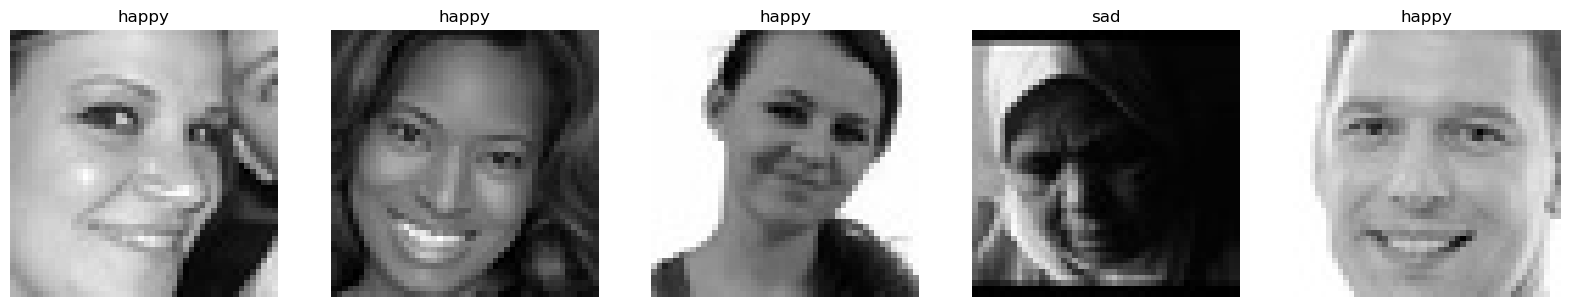

val set


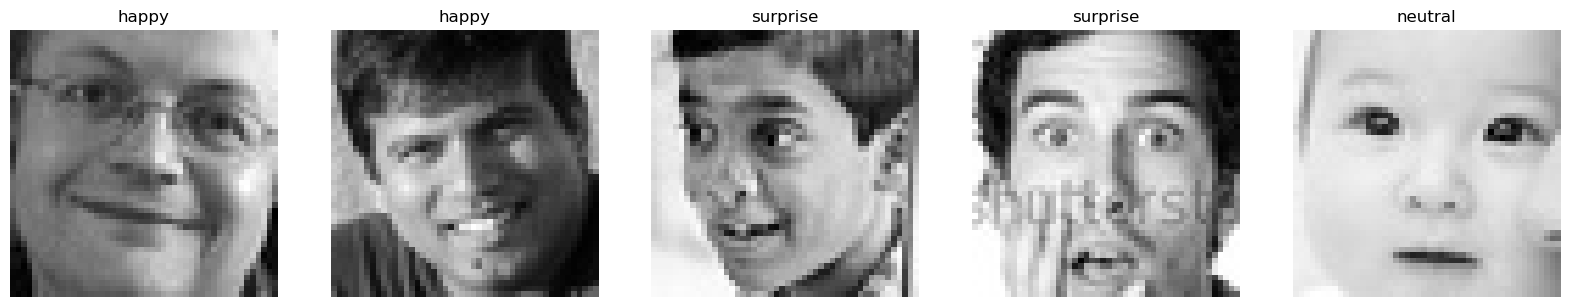

test set


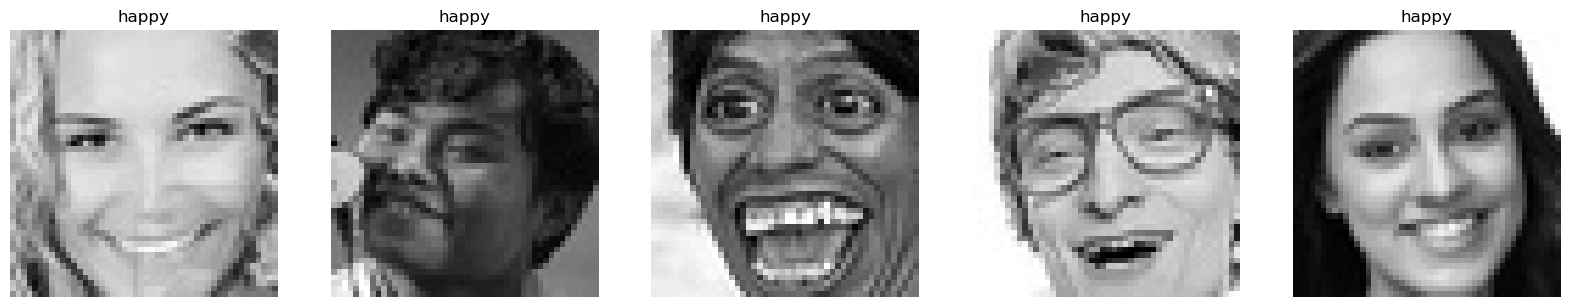

In [6]:
# Write a function to visualize images from a given data loader
# Note: Use titles to denote class label in words.
def visualize_dataloader(dataloader, class_names):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    images, labels = next(iter(dataloader))
    for i in range(5):
        axes[i].imshow(images[i].permute(1, 2, 0).squeeze(), cmap="gray")
        axes[i].set_title(class_names[labels[i].item()])
        axes[i].axis("off")
    plt.show()


# visualize images from the trainloader
print("train set")
visualize_dataloader(trainloader, class_names)

# visualize images from the valloader
print("val set")
visualize_dataloader(valloader, class_names)

# visualize images from the valloader
print("test set")
visualize_dataloader(testloader, class_names)

<div class="alert alert-block alert-info">

### Design your own CNN

Here are some guidelines in the CNN you can construct (you may stray away from this if you find other architectures are better):
- 4 convolutional layers
- Some (or all) of the convolutional layers can have pooling layers (this reduces size of feature maps well!)
- Test several activation functions (ReLU, sigmoid, tanh etc.) 
- Test different optimizers (SGD usually uses lr=0.1, ADAM usually uses lr=0.001, these are only guidelines and you can tweak the learning rates based on the datasets)

In [28]:
from typing import Literal
import typing

import torchmetrics.classification

Optimizers = Literal["sgd", "adam"]
Activations = Literal["sigmoid", "leaky_relu", "relu", "tanh"]

optimizers = typing.get_args(Optimizers)
activations = typing.get_args(Activations)


class MyCNN(pl.LightningModule):
    def __init__(
        self,
        num_classes: int,
        lr: float,
        optimizer: Optimizers,
        activation: Activations,
    ):
        super().__init__()
        self.save_hyperparameters()
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "leaky_relu":
            self.activation = nn.LeakyReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "tanh":
            self.activation = nn.Tanh()

        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)  # 32x48x48, 32x24x24
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)  # 64x24x24, 64x12x12
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)  # 128x12x12, 128x6x6
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)  # 256x6x6, 256x3x3

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.loss_fn = nn.CrossEntropyLoss()

        self.train_acc = torchmetrics.classification.MulticlassAccuracy(
            num_classes=num_classes
        )
        self.val_acc = torchmetrics.classification.MulticlassAccuracy(
            num_classes=num_classes
        )
        self.test_acc = torchmetrics.classification.MulticlassAccuracy(
            num_classes=num_classes, average="micro"
        )

    def on_train_start(self):
        for l in self.loggers:
            if isinstance(l, TensorBoardLogger):
                l.log_hyperparams(
                    self.hparams_initial,
                    {"hp/val_acc": 0, "hp/test_acc": 0, "hp/train_acc": 0},
                )

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = self.pool(x)
        x = self.activation(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

    def common_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        return loss, logits

    def training_step(self, batch, batch_idx):
        # Define logic for training step
        loss, logits = self.common_step(batch)
        acc = self.train_acc(logits, batch[1])
        log_dict = {
            "train_loss": loss,
            "train_acc": acc,
            "step": self.current_epoch,
        }
        self.log_dict(log_dict, on_step=False, on_epoch=True, prog_bar=True)
        self.log("hp/train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Define logic for validation step
        loss, logits = self.common_step(batch)
        acc = self.val_acc(logits, batch[1])
        log_dict = {
            "val_loss": loss,
            "val_acc": acc,
            "step": self.current_epoch,
        }
        self.log_dict(log_dict, on_step=False, on_epoch=True, prog_bar=True)
        self.log("hp/val_acc", acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Define logic for test step
        loss, logits = self.common_step(batch)
        acc = self.test_acc(logits, batch[1])
        log_dict = {
            "test_loss": loss,
            "test_acc": acc,
            "step": self.current_epoch,
        }
        self.log_dict(log_dict, on_step=False, on_epoch=True, prog_bar=True)
        self.log("hp/test_acc", acc, on_step=False, on_epoch=True)
        return loss

    def predict_step(self, batch, batch_idx):
        # Define logic for inference/prediction step
        x, y = batch
        logits = self(x)
        return logits, y, x

    def configure_optimizers(self):
        # Configure optimizers and schedulers
        if self.hparams_initial.optimizer == "adam":
            return torch.optim.Adam(self.parameters(), lr=self.hparams_initial.lr)
        elif self.hparams_initial.optimizer == "sgd":
            return torch.optim.SGD(self.parameters(), lr=self.hparams_initial.lr)

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader

    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

### Coarse hyperparameter sweep

In [ ]:
lrs = {"adam": [0.001, 0.005, 0.01, 0.05], "sgd": [0.05, 0.1, 0.5, 1]}
max_epochs = 10


class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.disable = True
        return bar


for activation in activations:
    for optimizer in optimizers:
        for lr in lrs[optimizer]:
            task3_model = MyCNN(
                num_classes=num_classes,
                lr=lr,
                optimizer=optimizer,
                activation=activation,
            )
            summary(task3_model, (1, 48, 48))  # delete .to('cuda') if not using cpu
            checkpoint_callback = ModelCheckpoint(
                dirpath="logs/task3/checkpoints",
                enable_version_counter=False,
                filename=f"{activation}_{optimizer}_{lr}-best",
                monitor="val_acc",
                save_top_k=1,  # save the best model based on validation accuracy
                mode="max",
                every_n_epochs=1,
            )
            trainer = pl.Trainer(
                max_epochs=max_epochs,
                callbacks=[checkpoint_callback],
                logger=[
                    CSVLogger(
                        "logs/task3/csv",
                        name=f"{activation}_{optimizer}_{lr}",
                        version=0,
                    ),
                    TensorBoardLogger(
                        "logs/task3/tensorboard",
                        name=f"{activation}_{optimizer}_{lr}",
                        version=0,
                    ),
                ],
            )
            trainer.fit(task3_model)

# Model design

## Initial parameter sweep

An initial coarse hyperparameter sweep was performed to find what combinations to fine-tune.
The parameter matrix tested was as follows:
- optimizers: adam, sgd
- activation functions: relu, leaky relu, sigmoid, tanh
- learning rates:
  - adam: 0.001, 0.005, 0.01, 0.05
  - sgd: 0.05, 0.1 , 0.5, 1

This inital sweep was done for 10 epochs.

### Results

Some hyperparameter combinations completely failed to train - all sigmoid sgd models, and higher learning rate sigmoid adam models and tanh adam and sgd models. These immediately converged on the average output, resulting in the accuracy being stuck at 25% (the model would output the same class for every input).

Other combinations were much more promising:

![](images/coarse-val-acc-table.png)

Looking at the results in Tensorboard, we see that using a relu/leaky relu activation function with the adam optimizer and a low learning rate seems to perform the best.

Specifically, the parameters:
- optimizer: adam
- activation: relu
- learning rate: 0.001

appeared to perform the best.

![](images/coarse-val-acc-graph.png)
![](images/coarse-val-loss-graph.png)

From the graphs of the validation loss and accuracy for those hyperparameters, there is still more performance that can be gained simply by training for more epochs.
Therefore the next step will be performing a finer sweep on the following hyperparameters:
- optimizer: adam
- activation: relu, leaky relu
- learning rates: 0.0001, 0.005, 0.001

Only lower learning rates will be tested as the previous sweep already showed that higher learning rates  performed worse.

### Fine sweep

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping  # type: ignore

optimizer = "adam"
activations: list[Activations] = ["relu", "leaky_relu"]
lrs = [0.001, 0.0011, 0.009]
max_epochs = 40

for activation in activations:
    for lr in lrs:
        task3_model = MyCNN(
            num_classes=num_classes,
            lr=lr,
            optimizer=optimizer,
            activation=activation,
        )
        summary(task3_model, (1, 48, 48))
        checkpoint_callback = ModelCheckpoint(
            dirpath="logs/task3/fine/checkpoints",
            enable_version_counter=False,
            filename=f"{activation}_{optimizer}_{lr}-best",
            monitor="val_acc",
            save_top_k=1,  # save the best model based on validation accuracy
            mode="max",
            every_n_epochs=1,
        )
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            callbacks=[
                checkpoint_callback,
                EarlyStopping(
                    monitor="val_acc", patience=5, min_delta=0.005, mode="max"
                ),
            ],
            logger=[
                CSVLogger(
                    "logs/task3/fine/csv",
                    name=f"{activation}_{optimizer}_{lr}",
                    version=0,
                ),
                TensorBoardLogger(
                    "logs/task3/fine/tensorboard",
                    name=f"{activation}_{optimizer}_{lr}",
                    version=0,
                ),
            ],
        )
        trainer.fit(task3_model)

## Fine parameter sweep

![](images/fine-val-acc.png)

With a more fine-grained sweep of learning rates on adam, relu and leaky relu, the optimal hyperparameters were the following:
- optimizer: adam
- activation: leaky relu
- learning rate: 0.0011

### Define progress bar and checkpoint callback functions 

### Train the CNN

In [ ]:
%tensorboard --logdir logs

In [18]:
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[
        EarlyStopping(monitor="val_acc", patience=5, min_delta=0.005, mode="max"),
    ],
    logger=[
        CSVLogger(
            "logs/task3/fine/csv",
            name=f"leaky_relu_adam_0.0011",
            version=0,
        ),
    ],
)
model = MyCNN(
    num_classes=num_classes, lr=0.0011, optimizer="adam", activation="leaky_relu"
)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs

   | Name       | Type               | Params | Mode 
-----------------------------------------------------------
0  | activation | LeakyReLU          | 0      | train
1  | conv1      | Conv2d             | 160    | train
2  | conv2      | Conv2d             | 4.6 K  | train
3  | conv3      | Conv2d             | 18.5 K | train
4  | conv4      | Conv2d             | 73.9 K | train
5  | pool       | MaxPool2d          | 0      | train
6  | fc1        | Linear             | 73.8 K | train
7  | fc2        | Linear             | 260    | train
8  | loss_fn    | CrossEntropyLoss   | 0      | train
9  | train_acc  | MulticlassAccuracy | 0      | train
10 | val_acc    | MulticlassAccuracy | 0      | train
11 | test_acc   | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)
12        M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Test the CNN

For a propoer trained network, you may achieve an accuracy for at least 65%

In [29]:
task3_model = MyCNN.load_from_checkpoint(
    "logs/task3/fine/checkpoints/leaky_relu_adam_0.0011-best.ckpt"
)
task3_trainer = pl.Trainer()
task3_trainer.test(task3_model, dataloaders=testloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/nix/store/ps8bfxcyy0r4j1c6ynjvr6zn0q03kj3r-python3-3.12.4-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       hp/test_acc          0.6863323450088501
          step                      0.0
        test_acc            0.6863323450088501
        test_loss            0.913185715675354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.913185715675354,
  'test_acc': 0.6863323450088501,
  'step': 0.0,
  'hp/test_acc': 0.6863323450088501}]

### Read logs

In [20]:
metrics_task_3 = pd.read_csv(
    "logs/task3/fine/csv/leaky_relu_adam_0.0011/version_0/metrics.csv"
)
metrics_task_3.set_index("step", inplace=True)
metrics_task_3 = metrics_task_3.groupby(level=0).sum()

print(metrics_task_3)

      hp/train_acc  hp/val_acc  train_acc  train_loss   val_acc  val_loss
step                                                                     
0.0       0.328333    0.470847   0.328333    1.279019  0.470847  1.134483
1.0       0.535684    0.573708   0.535684    1.031358  0.573708  0.984211
2.0       0.599689    0.593679   0.599689    0.905533  0.593679  0.912975
3.0       0.638910    0.602716   0.638910    0.825999  0.602716  0.880218
4.0       0.673338    0.649215   0.673338    0.750387  0.649215  0.806111
5.0       0.702870    0.663288   0.702870    0.697637  0.663288  0.800893
6.0       0.739524    0.667577   0.739524    0.636474  0.667577  0.790864
7.0       0.761718    0.676600   0.761718    0.574381  0.676600  0.784794
8.0       0.790572    0.682053   0.790572    0.520782  0.682053  0.779360
9.0       0.809143    0.676160   0.809143    0.470713  0.676160  0.844350
10.0      0.843481    0.669111   0.843481    0.396353  0.669111  0.892638
11.0      0.872082    0.674549   0.872

### Plot train and validation losses against epoch

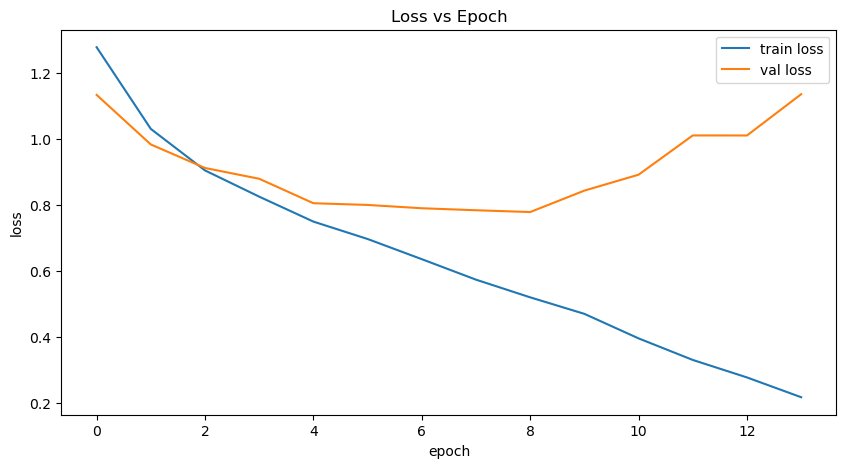

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_task_3["train_loss"], label="train loss")
plt.plot(metrics_task_3["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train loss", "val loss"])
plt.title("Loss vs Epoch")
plt.show()

### Plot train and validation accuracies against epoch

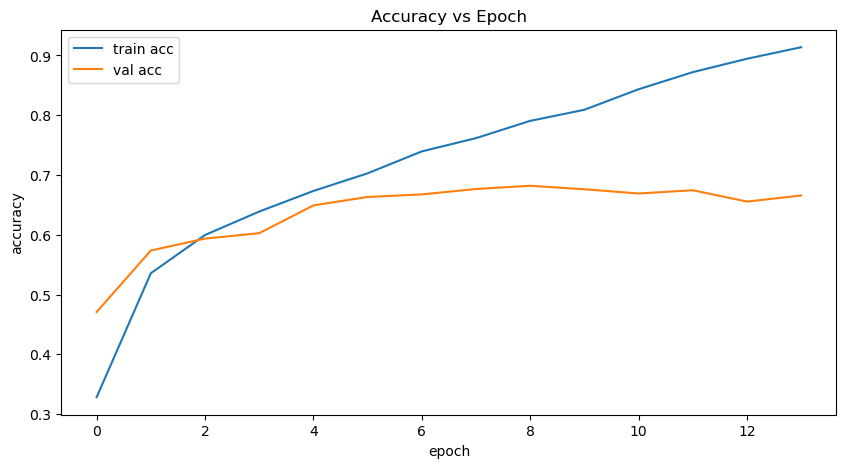

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_task_3["train_acc"], label="train acc")
plt.plot(metrics_task_3["val_acc"], label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train acc", "val acc"])
plt.title("Accuracy vs Epoch")
plt.show()

### Get predictions for the test set for later use 

In [31]:
## These are the predictions for the test set. You will use this for the tasks below during the analysis process.

predictions = task3_trainer.predict(
    task3_model, testloader
)  # do not do anything to the variable 'predictions' you will reuse it

test_outputs = torch.concat([prediction[0] for prediction in predictions], dim=0)  # type: ignore
test_labels = torch.concat([prediction[1] for prediction in predictions], dim=0)  # type: ignore
test_inputs = torch.concat([prediction[2] for prediction in predictions], dim=0)  # type: ignore
test_preds = test_outputs.argmax(dim=1)

Predicting: |          | 0/? [00:00<?, ?it/s]

### Confusion Matrix

Ensure you use **proportion** instead of absolute value. Create the confusion matrix for the four classes.

In [34]:
# Plot the confusion matrix
# You can create a ConfusionMatrix instance for multiclass classification with 'num_classes' from the lightning library

matrix = torchmetrics.ConfusionMatrix(
    task="multiclass", num_classes=num_classes, normalize="true"
)
matrix(test_preds, test_labels)

tensor([[0.8433, 0.0575, 0.0671, 0.0321],
        [0.1817, 0.5036, 0.2555, 0.0592],
        [0.1540, 0.2189, 0.5710, 0.0561],
        [0.0830, 0.0481, 0.0734, 0.7954]])

### Top Misclassified

You will only plot the top misclassified classes here. Please plot 5 images of each class (so 20 images in total). This will be similar to the basics notebook.

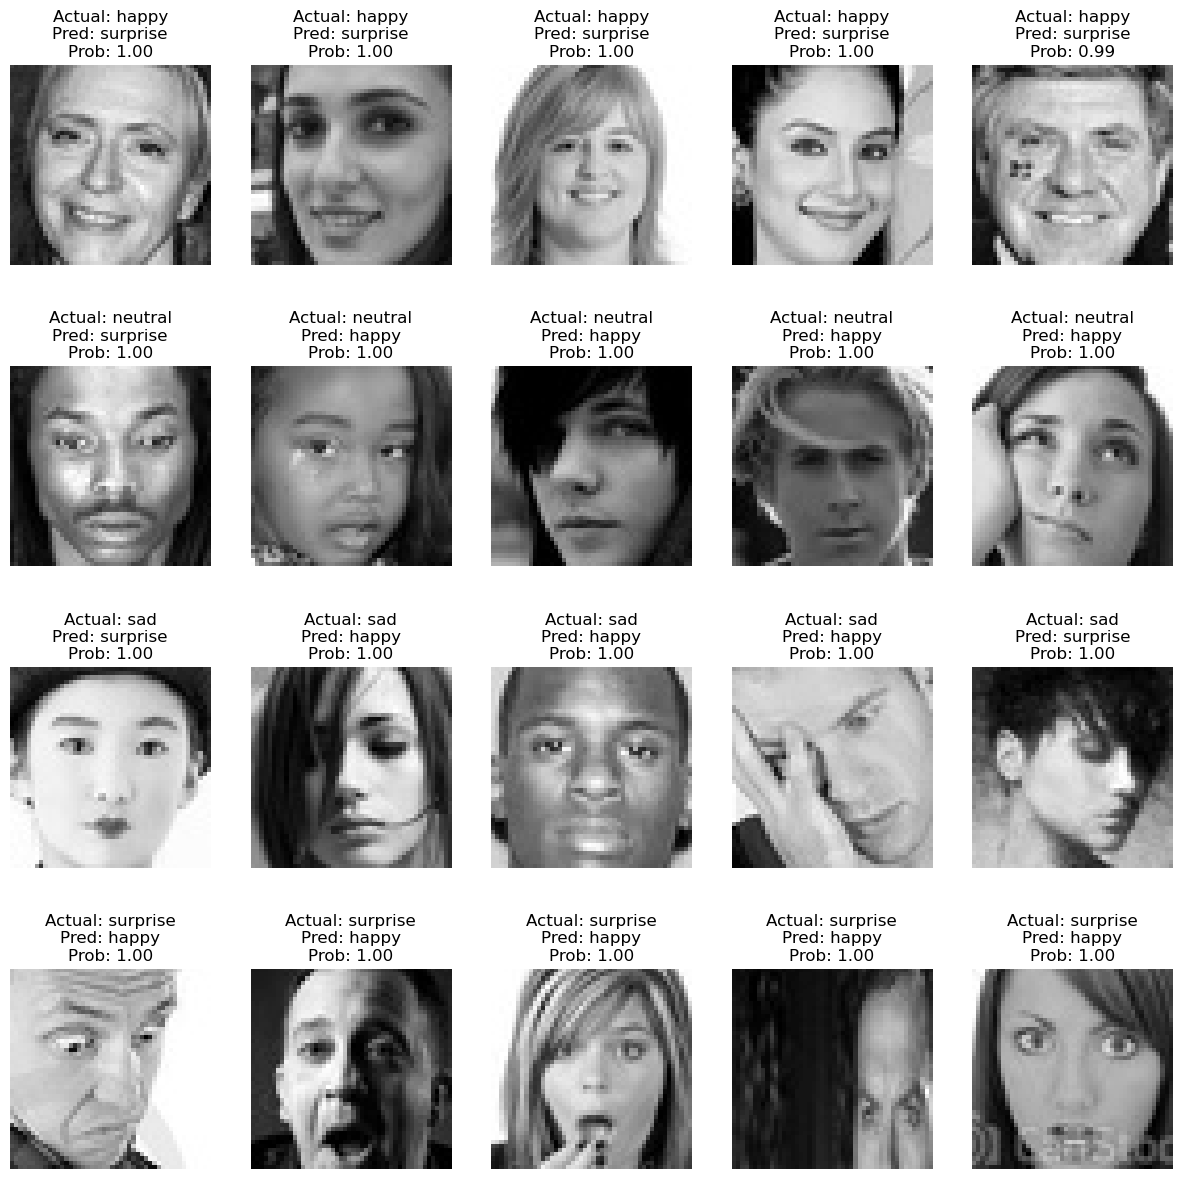

In [40]:
plt.figure(figsize=(15, 15))
for c in range(num_classes):
    idx = test_labels == c  # Get the indices of the current class
    r_preds = test_preds[idx]
    r_inputs = test_inputs[idx]
    r_outputs = test_outputs[idx]
    incorrect = r_preds != c  # Get the incorrect predictions for the current class
    probs = softmax(
        r_outputs[incorrect], dim=1
    )  # Get the probabilities for the current class
    max_probs = torch.max(probs, dim=1)
    top_5 = torch.topk(max_probs.values, 5, sorted=True)  # Get the top 5 probabilities
    for i in range(5):
        plt.subplot(num_classes, 5, c * 5 + i + 1)
        img = r_inputs[top_5.indices[i]].permute(1, 2, 0) * 0.5 + 0.5
        plt.imshow(img, cmap="gray")
        plt.title(
            f"Actual: {class_names[c]}\nPred: {class_names[max_probs.indices[top_5.indices[i]]]}\nProb: {top_5.values[i]:.2f}"
        )
        plt.axis("off")

### Saliency Map

Plot a saliency map corresponding to a happy face that was classified correctly

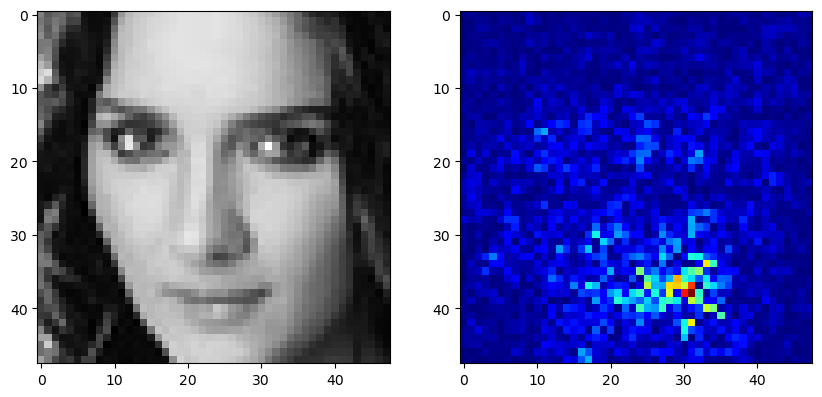

In [73]:
happy = torch.where(test_labels == 0)
test_preds = test_preds[happy]
test_labels = test_labels[happy]
test_inputs = test_inputs[happy]
test_outputs = test_outputs[happy]

correct_idxs = torch.where(test_preds == test_labels)

# Select a random index from the correctly classified samples
index = random.choice(correct_idxs[0].tolist())

# Retrieve the image, true label, model output, predicted label for the selected index
image = test_inputs[index]
img = test_inputs[index].permute(1, 2, 0) * 0.5 + 0.5
true_label = test_labels[index]
model_output = test_outputs[index]
pred_label = test_preds[index]

# Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
image = image.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
# To compute the scores, do a forward pass of the image and then take the argmax
# Use this index to extract the score_max value from "scores"
# Then perform a backward step so that it backpropagates the gradient
scores = task3_model(image)
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]
score_max.backward()  # Do the backward step here for the gradient calculation

# Calculate the saliency map by finding the maximum absolute gradient values across channels
# You can use .abs() and torch.max()
sal_map, _ = image.grad.abs().max(dim=1)  # type: ignore

# Create a subplot to display the original image and saliency map side by side
plt.figure(figsize=(10, 5))

# Display the original image with proper unnormalization
# Do this in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")

# Display the saliency map
# Do this in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(sal_map.squeeze().detach().cpu(), cmap="jet")

# Show the original image and saliency map side by side
plt.show()

### My own image

Use an image of yourself being happy - hopefully you are proud of your results! Make sure you output the predicted result

torch.Size([1, 1, 48, 48])


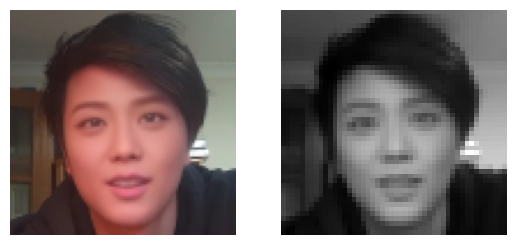

In [87]:
# Read in your image here (we used mpimg.imread and you just need to pass in the path to your image)
# Feel free to use any other image reading functions instead
img = mpimg.imread("images/me-happy.png")[
    :, :, 0:3
]  # get rid of the 4th axis if exists
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 2, 2)
img = val_test_transforms(img).unsqueeze(0)  # type: ignore
print(img.shape)
plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

In [98]:
# Pass your image through the network
# Remember to apply the val_test_transforms for your image before doing a forward pass of your model

logits, y, x = task3_model.predict_step((img, 0), 0)
pred = torch.argmax(logits, dim=1)
print(f"Predicted class: {class_names[pred.item()]}")  # type: ignore

Predicted class: sad


<div class="alert alert-block alert-success">

## Discussion Questions <a class="anchor" id="t3_1"></a>
    
#### Comment on the resulting confusion matrix.
    
Answer: 

#### What was the strange thing that you observed in the actual labels when visualizing the misclassified images?
    
Answer: 
    
#### Comment on the saliency map of the 'happy' image.
    
Answer: 
    
#### Comment on the prediction results of your own data.
    
Answer:

<div class="alert alert-block alert-danger">

#### This is the end of Notebook II. Hurrah! You have now completed all the Labs for this unit! It's time to reward yourself with an assignment!!!